# BMG standard curve exploration

This ipynb explores standard curve data acquired from a BMG CLARIOstar Plus plate reader. The overall aim is to identify a common data analysis pipeline for this and similar data.

## Aims and objectives for cell/s below

- [x] Import plate reader data into pandas in a useable format.
- [x] Fit a linear model using OLS.
- [ ] Generate the following plots:
  - [x] Calibration curve.
  - [x] Plot of studentised residuals - tests if the assumption of homoskedasticity is valid.

In [83]:
import pandas as pd
import numpy as np
from pathlib import Path
import statsmodels.api as sm
from patsy import dmatrices
import matplotlib.pyplot as plt
import numpy.typing as npt

In [98]:
DATETIME = datetime.now()
DATETIME.strftime("%Y-%m-%d_%H%M%S")

'2022-04-14_181502'

In [68]:
PATH_TO_CSVS = Path.cwd().parents[0] / "csv_xlsx_files"
data = pd.read_csv(
    PATH_TO_CSVS / "22-03-25_19-01-53_pierce_gfp_standard.CSV",
    header=3
)
data.drop("Unnamed: 5", axis=1, inplace=True)
data.dropna(inplace=True)
# data = data.iloc[:15] # Drop data that is outside the linear region of quantification
data.rename(
    {
        "Standard Concentrations": "concentration",
        " Blank corrected based on Raw Data (F: 482-16/525-20)": "fluorescence"
    },
    inplace=True,
    axis=1
)

In [69]:
response, predictors = dmatrices(
    "concentration ~ fluorescence",
    data=data,
    return_type="dataframe"
)

In [70]:
ols_model = sm.OLS(
    response,
    predictors
)
ols_fit = ols_model.fit()
ols_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          concentration   R-squared:                       0.992
Model:                            OLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                     4623.
Date:                Thu, 14 Apr 2022   Prob (F-statistic):           1.83e-40
Time:                        14:57:04   Log-Likelihood:                -91.120
No. Observations:                  39   AIC:                             186.2
Df Residuals:                      37   BIC:                             189.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.9925      0.463      2.145      0.039       0.055       1.930
fluorescence     0.0004   6.49e-06     67.992      0.000       0.000       0.000
==============================================================================
Omnibus:                       39.931   Durbin-Watson:                   0.720
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              137.798
Skew:                           2.435   Prob(JB):                     1.20e-30
Kurtosis:                      10.816   Cond. No.                     8.01e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.01e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

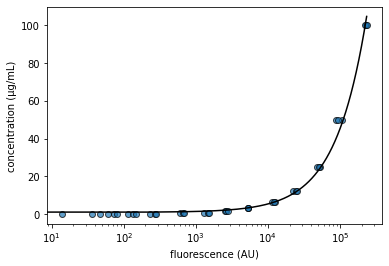

In [80]:
plt.scatter(
    data["fluorescence"],
    data["concentration"],
    alpha=0.7,
    edgecolors="k"
)
x_vals = np.linspace(0, int(round(data["fluorescence"].max())), int(1e3))
plt.plot(
    x_vals,
    x_vals*ols_fit.params[1] + ols_fit.params[0],
    color="k" 
)
plt.ylabel("concentration (μg/mL)")
plt.xlabel("fluorescence (AU)")

Text(0.5, 0, 'concentration (μg/mL)')

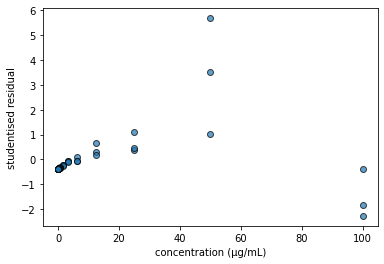

In [72]:
student_resid = ols_fit.outlier_test()["student_resid"]
plt.scatter(
    data["concentration"],
    student_resid,
    alpha=0.7,
    edgecolors="k"
)
plt.ylabel("studentised residual")
plt.xlabel("concentration (μg/mL)")

In [81]:
type(student_resid)

numpy.ndarray

## Results and discussion

- From the plot of studentised residuals, the data shows heteroskedasticity with variance increasing as a function of analyte concentration. Weighted linear regression should be attempted to increase the confidence in the predicted model parameters.
- Heteroskedasticity is also indicated from `Durbin-watson` parameter from the summary which is not between 1 - 2. The `Prob(Omnibus)` value suggests that the errors are not normally distributed which is another requirement for OLS.

## Aims and objectives for cell/s below

- [x] Fit a linear model using weighted least squares regression using the following weightings:
  - [x] `1/concentration`
  - [x] `1/concentration**2`
- [x] Analyse the models to see if the confidence in model parameters increases.


In [73]:
inv_wsl_mod = sm.WLS(
    response,
    predictors,
    weights=1/data["concentration"]
)
print(inv_wsl_mod.fit().summary())

                            WLS Regression Results                            
Dep. Variable:          concentration   R-squared:                       0.989
Model:                            WLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                     3458.
Date:                Thu, 14 Apr 2022   Prob (F-statistic):           3.77e-38
Time:                        14:57:06   Log-Likelihood:                -28.435
No. Observations:                  39   AIC:                             60.87
Df Residuals:                      37   BIC:                             64.20
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.0310      0.026      1.180   

In [74]:
inv2_wls_mod = sm.WLS(
    response,
    predictors,
    weights=1/data["concentration"]**2
)
print(inv2_wls_mod.fit().summary())

                            WLS Regression Results                            
Dep. Variable:          concentration   R-squared:                       0.968
Model:                            WLS   Adj. R-squared:                  0.968
Method:                 Least Squares   F-statistic:                     1133.
Date:                Thu, 14 Apr 2022   Prob (F-statistic):           2.36e-29
Time:                        14:57:07   Log-Likelihood:               -0.30265
No. Observations:                  39   AIC:                             4.605
Df Residuals:                      37   BIC:                             7.932
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.0095      0.002      4.525   

## Results and discussion

- Using a weighting of `1/concentration` decreases our confidence in the intercept value from P=0.07 to P=0.246, suggesting this weighting shouldn't be used.
- Using a weighting of `1/concentration**2` increases our confidence in the intercept value from P=0.07 to P=0, suggesting this weighting should be used. This conclusion is supported by previous literature (10.1021/ac5018265).

## Aims and objectives for the cell/s below

- [x] Using plots of relative errors, compare the accuracy of OLS with WLS.
- [x] Select a suitable range of values to use for the standard curve, ensuring relative error doesn't exceed 15% and residuals are 

In [75]:
wls_fit = inv2_wls_mod.fit()

In [76]:
def calculate_relative_errors(
    abs_val: npt.ArrayLike,
    lm_fit: None,
) -> npt.ArrayLike:
    """Calculate relative errors from a linear model.
    
    Args:
        abs_val: Absolute value from data.
        lm_fit: Linear model object.
    
    """
    return np.absolute((lm_fit.resid/abs_val*100).to_numpy())

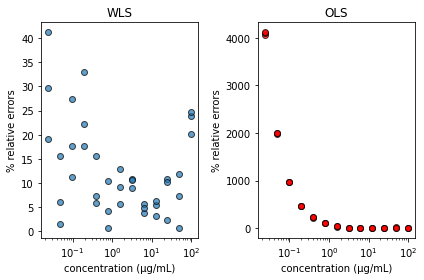

In [77]:
wls_errors = calculate_relative_errors(data["concentration"], wls_fit)
ols_errors = calculate_relative_errors(data["concentration"], ols_fit)

figure, axs = plt.subplots(nrows=1, ncols=2)

for ax in axs:
    ax.set_ylabel("% relative errors")
    ax.set_xlabel("concentration (μg/mL)")
    ax.set_xscale("log")

axs[0].scatter(
    data["concentration"],
    wls_errors,
    alpha=0.7,
    edgecolors="k"
)
axs[0].set_title("WLS")

axs[1].scatter(
    data["concentration"],
    ols_errors,
    alpha=0.7,
    edgecolors="k",
    facecolor="r"
)
axs[1].set_title("OLS")
plt.tight_layout()

Max absolute studentised residual:  1.556641016983156
Max % relative error:               10.996375191678927
Min concentration (μg/mL):          0.195
Max concentration (μg/mL):          50.0


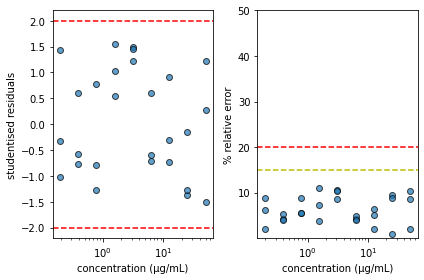

In [78]:
data2 = pd.read_csv(
    PATH_TO_CSVS / "22-03-25_19-01-53_pierce_gfp_standard.CSV",
    header=3,
    nrows=10*3
)
data2 = data2.iloc[3:, :]
data2.dropna(
    axis=1,
    how="all",
    inplace=True
)
data2.dropna(inplace=True)
data2.rename(
    {
        "Standard Concentrations": "concentration",
        " Blank corrected based on Raw Data (F: 482-16/525-20)": "fluorescence"
    },
    inplace=True,
    axis=1
)
response, predictors = dmatrices(
    "concentration ~ fluorescence",
    data=data2,
    return_type="dataframe"
)
wls_mod = sm.WLS(
    response,
    predictors,
    weights=1/data2["concentration"]**2
)
wls_fit = wls_mod.fit()
wls_errors = calculate_relative_errors(
    data2["concentration"],
    wls_fit    
)

res = sm.OLS(wls_mod.wendog, wls_mod.wexog).fit()
student_resid = res.get_influence().resid_studentized

figure, axs = plt.subplots(nrows=1, ncols=2)

for ax in axs:
    ax.set_xscale("log")
    ax.set_xlabel("concentration (μg/mL)")


axs[0].scatter(
    data2["concentration"],
    student_resid,
    alpha=0.7,
    edgecolors="k"
)
axs[0].set_ylabel("studentised residuals")
axs[0].axhline(y=2, color="r", linestyle="--")
axs[0].axhline(y=-2, color="r", linestyle="--")

axs[1].scatter(
    data2["concentration"],
    wls_errors,
    alpha=0.7,
    edgecolors="k"    
)
axs[1].axhline(y=15, color='y', linestyle='--')
axs[1].axhline(y=20, color='r', linestyle='--')
axs[1].set_ylabel("% relative error")
axs[1].set_ylim(top=50)
plt.tight_layout()
print(f"{'Max absolute studentised residual:': <35} {max(np.absolute(student_resid))}")
print(f"{'Max % relative error:': <35} {max(wls_errors)}")
print(f"{'Min concentration (μg/mL):': <35} {np.min(data2['concentration'])}")
print(f"{'Max concentration (μg/mL):': <35} {np.max(data2['concentration'])}")

In [79]:
wls_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:          concentration   R-squared:                       0.993
Model:                            WLS   Adj. R-squared:                  0.993
Method:                 Least Squares   F-statistic:                     3477.
Date:                Thu, 14 Apr 2022   Prob (F-statistic):           2.35e-28
Time:                        14:57:11   Log-Likelihood:                 3.0883
No. Observations:                  27   AIC:                            -2.177
Df Residuals:                      25   BIC:                            0.4150
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.0584      0.008      7.256      0.000       0.042       0.075
fluorescence     0.0005   8.89e-06     58.963      0.000       0.001       0.001
==============================================================================
Omnibus:                        9.904   Durbin-Watson:                   1.498
Prob(Omnibus):                  0.007   Jarque-Bera (JB):                2.259
Skew:                           0.039   Prob(JB):                        0.323
Kurtosis:                       1.585   Cond. No.                     1.04e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.04e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Results and discussion

- Compared to WLS regression, using OLS to fit a standard curve for the data results in large relative errors at low concentrations of analyte. This highlights its inappropriate use in this case.
- By dropping data points the accuracy of the standard curve improves such that % relative errors are below 15 % and studentised residuals are between [-2, 2]. Properties that indicate good linearity of a standard curve (10.1016/j.trac.2015.12.006 & 10.1016/j.talanta.2017.05.049).
- Of note dropping data from 100 μg/mL standard concentration was required to ensure good linearity. It is unclear why this was required as the gain of the instrument was automatically set to yield 90 % max signal for this concentration.

## Suggested method for generating standard curves

1. Import data and format:
   1. Identify `response` and `standard_concentrations` data series.
   2. Remove `NAN` values.
2. Fit a model using OLS regression.
3. Run the following analysis:
   1. Plot a standard curve
   2. Plot studentised residuals
   3. Plot % relative error
   4. Generate a summary of the fit
   5. Summarise the linearity with the following parameters:
      1. Max absolute studentised residual
      2. Max % relative error
      3. Min concentration
      4. Max concentration
4. Examine the studentised residual plot and summary to determine if WLS regression is required.
5. If WLS is required repeat step 3 using selected weights, typically `1/standard_concentrations**2`.
6. Examine studentised residual and % relative error plots to determine if data points are outside the linear region. If so remove values and repeat step 3.

## Candidate parameters

1. csv file path
2. csv file header
3. standard concentrations column name
4. response column name
5. Fitting method (WLS or OLS)
6. *weights for regression*
7. output directory path

## Hard coded behaviours

- Will remove NAN values from Data Series.